In [231]:
# !pip install ydata_profiling
# !pip install scikit-learn
# !pip install category_encoders

In [257]:
import numpy as np
import sqlite3
import pandas as pd
import ydata_profiling
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
%matplotlib inline

In [233]:
path_to_db='/content/drive/MyDrive/Colab Notebooks/ML/Lab 3/ml-labs-data.db'

with sqlite3.connect(path_to_db) as conn:
    covid19_df = pd.read_sql_query(('SELECT * FROM covid19_self_practice'), con=conn, parse_dates=['test_date'])

covid19_df.drop('index', axis=1, inplace=True)
covid19_df.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,age,medical_id
0,2021-01-03,0,0,0,0,0,Negative,Yes,male,Other,87,MX0x0
1,2020-10-08,0,0,0,0,0,Negative,No,male,Other,24,MX0x1
2,2021-02-07,0,0,0,0,0,Positive,No,female,Contact with confirmed,57,MX0x2
3,2020-10-12,0,0,0,0,0,Negative,Yes,female,Other,63,MX0x3
4,2020-10-29,0,0,0,0,0,Negative,No,female,Other,39,MX0x4


In [234]:
profile_report = ydata_profiling.profile_report.ProfileReport(covid19_df)
# profile_report.to_file('covid_profile.html')

## <center>Self-Practice  Task</center>

* Using `covid19-2.csv` dataset given to you.
    1. Split the data to train and test set (80% training). Use [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    1. Fill missing values
    1. Encode categorical features
    1. Create new features from the existing features
    1. Train a logistic regression model that will predict if a person is infected by COvid-19 `(corona_result)`.
    1. Select the optimal prediction threshold
    1. Calculate Accuracy, Precision, and Recall values for each of the given threshold values and plot them.

In [235]:
corona_result_dict = {'Negative':0, 'Positive':1}
covid19_df['corona_result'].replace(corona_result_dict, inplace=True)

covid19_df.sort_values(by='test_date')
covid19_df_no_medical_id_no_test_date = covid19_df.drop(columns=['medical_id','test_date'])

In [236]:
y = covid19_df_no_medical_id_no_test_date['corona_result']
X = covid19_df_no_medical_id_no_test_date.drop('corona_result', axis=1)

In [237]:
# Split the data to train and test set (80% training)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

In [238]:
profile_report = ydata_profiling.profile_report.ProfileReport(X_train)
# profile_report.to_file('covid_profile.html')

In [239]:
X_train_clear = X_train[X_train['gender'].notna() | X_train['test_indication'].notna()] # можно ли сделать это до разделения данных?
X_test_clear = X_test[X_test['gender'].notna() | X_test['test_indication'].notna()] # можно ли сделать это до разделения данных? # Нужно ли это делать с тестовыми данными?
y_train_clear = y_train[X_train['gender'].notna() | X_train['test_indication'].notna()] # можно ли сделать это до разделения данных?
y_test_clear = y_test[X_test['gender'].notna() | X_test['test_indication'].notna()] # можно ли сделать это до разделения данных? # Нужно ли это делать с тестовыми данными?

In [240]:
# Fill missing values
def fillna_need_col(col_need_fill, train, test):
  train_copy = train.copy()
  test_copy = test.copy()

  for col in col_need_fill:
    most_common = X[col].mode()[0]
    train_copy[col] = train_copy[col].fillna(most_common)
    test_copy[col] = test_copy[col].fillna(most_common) # Нужно ли это делать с тестовыми данными?

  return [train_copy, test_copy]

col_need_fill = ['gender', 'test_indication']
X_train_clear_fillna, X_test_clear_fillna = fillna_need_col(col_need_fill, X_train_clear, X_test_clear)

In [241]:
# Нужно ли устранить дисбаланс данных в колонке test_indication?

In [242]:
# Encode categorical features
encoder = OneHotEncoder(cols=['age_60_and_above', 'gender', 'test_indication'], handle_unknown='ignore', use_cat_names=True)
X_train_clear_fillna_encoded = encoder.fit_transform(X_train_clear_fillna)
X_test_clear_fillna_encoded = encoder.transform(X_test_clear_fillna)

In [243]:
# Create new features from the existing features
X_train_clear_fillna_encoded['symptom_count'] = X_train_clear_fillna_encoded[['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']].sum(axis=1)
X_test_clear_fillna_encoded['symptom_count'] = X_test_clear_fillna_encoded[['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']].sum(axis=1)
# Нужно ли проработать нули в новом столбце?

In [254]:
# feature scaling using MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train_clear_fillna_encoded)
X_train = pd.DataFrame(scaler.transform(X_train_clear_fillna_encoded), columns=X_train_clear_fillna_encoded.columns)
X_test = pd.DataFrame(scaler.transform(X_test_clear_fillna_encoded), columns=X_test_clear_fillna_encoded.columns)
y_train = y_train_clear
y_test = y_test_clear

In [245]:
profile_report = ydata_profiling.profile_report.ProfileReport(X_train)
# profile_report.to_file('covid_profile.html')

In [250]:
# Train a logistic regression model that will predict if a person is infected by COvid-19 (corona_result)
model = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
# calculate metrics
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred)))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


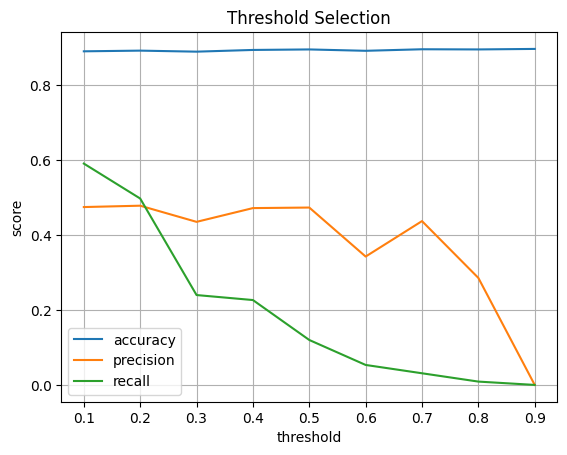

In [258]:
# Select the optimal prediction threshold
# Calculate Accuracy, Precision, and Recall values for each of the given threshold values and plot them
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
pred_proba = model.predict_proba(X_test)

results = [[],[],[]]
for i in thresholds:
    y_test_pred_thr = np.where(pred_proba[:, 1] > i, 1, 0)
    results[0].append(metrics.accuracy_score(y_test, y_test_pred_thr))
    results[1].append(metrics.precision_score(y_test, y_test_pred_thr))
    results[2].append(metrics.recall_score(y_test, y_test_pred_thr))

plt.plot(thresholds, results[0], label = 'accuracy')
plt.plot(thresholds, results[1], label = 'precision')
plt.plot(thresholds, results[2], label = 'recall')
plt.title('Threshold Selection')
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.grid()